In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from grav_lens.models.load_models import load_minmaxscaler, load_ipca_low
# Cargar el MinMaxScaler
minmaxscaler = load_minmaxscaler()
print(minmaxscaler)
# Cargar el modelo IPCA low
ipca_low = load_ipca_low()
print(ipca_low)


from grav_lens import get_datasets
max_files = 2000
batch_size = 64
home_data = os.path.join("..","data")

train_dataset, val_dataset, test_dataset = get_datasets(
    data_index=1,
    max_files=max_files,
    home=home_data,
    batch_size=batch_size,
    val_split=0.2,
    test_split=0.1,
)

for X_batch, y_batch in train_dataset.take(1):
    print(X_batch.shape)
    print(y_batch.shape)



IncrementalPCA(batch_size=64, n_components=64)
Using data folder: ..\data\1
(64, 128, 128, 3)
(64, 128, 128, 1)


In [9]:
import grav_lens.preprocess as gp
from grav_lens.utils.statistics import get_stats
from grav_lens.preprocess.filtering import process_batch_filters

## Mini tutorial de las funciones más usadas
Algunas funciones de utilidad
- gp.apply_threshold
- gp.gmm_batch_vectors

In [18]:
# se puede separar por encima o abjao de un punto de corte
batch_positive, batch_negative =   gp.apply_threshold(y_batch, *get_stats(y_batch))

In [21]:
# separa en baja y alta frecuencia 5.2 s por batch
low_batch, high_batch = process_batch_filters(y_batch)

- Los componentes de baja frecuencia son bien aproximados por componentes principales
- Los componentes de alta frecuencia son bien aproximados por peaks gaussianos

In [24]:
gp.gmm_batch_vectors?

Signature:
gp.gmm_batch_vectors(
    batch,
    n_gaussians_positive=30,
    n_gaussians_negative=10,
    threshold=2,
)
Docstring:
Aplica modelos de mezclas gaussianas (GMM) a un batch de imágenes, generando vectores de medias, desviaciones estándar y pesos para cada imagen.

Parámetros:
    batch (numpy array): Batch de imágenes a procesar (batch_size, altura, anchura, 1).
    n_gaussians_positive (int, opcional): Número de componentes gaussianas positivas (por defecto 30).
    n_gaussians_negative (int, opcional): Número de componentes gaussianas negativas (por defecto 10).
    threshold (float, opcional): Umbral para separar las frecuencias (por defecto 2).

Retorna:
    combined_batch (numpy array): Batch de vectores combinados de medias, desviaciones estándar y pesos de cada imagen,
                                  con shape (batch_size, n_gaussianas, 5). El vector tiene el formato 
                                  [mean_x, mean_y, std_x, std_y, weight] para cada gaussiana.
Fil

In [26]:
# 15 s por batch
# (batch, 40, 5) 
# 40 es el total de gaussianas
# 5 el vector correspondiente a cada gaussiana
gaussians = gp.gmm_batch_vectors(high_batch)

(64, 40, 5)

# El proceso completo
De manera que tenemos las dos formas principales de datos
- gaussians (batch, 40, 5), con 40 el total de gaussianas, 5 el largo del vector de info: 
    meanx, meany, stdx, stdy, coef
- principal_components (batch, 64), con 64 coeficientes que representan cuanto hay de cada componente


In [27]:
for X_batch, y_batch in train_dataset.take(1):
    y_batch = minmaxscaler.transform(y_batch) # [0, 1] #escalar los datos

    print(X_batch.shape)
    print(y_batch.shape)
    
    low_batch, high_batch = process_batch_filters(y_batch)

    gaussians = gp.gmm_batch_vectors(high_batch)

    low_freq_stack = np.vstack([img.reshape(-1, 128*128) for img in low_batch]) #stack para el pca
    principal_components = ipca_low.transform(low_freq_stack)


(64, 128, 128, 3)
(64, 128, 128, 1)


In [ ]:
def preprocess_ybatch(y_batch):
    low_batch, high_batch = process_batch_filters(y_batch)

    gaussians = gp.gmm_batch_vectors(high_batch)

    low_freq_stack = np.vstack([img.reshape(-1, 128*128) for img in low_batch]) #stack para el pca
    principal_components = ipca_low.transform(low_freq_stack)
    return [principal_components, gaussians]

### Creacion del Modelo

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Función para construir el modelo CNN con dos ramas
def create_cnn_model(input_shape=(128, 128, 3)):
    """
    Crea un modelo CNN con dos ramas para predecir coeficientes de baja y alta frecuencia.

    Parámetros:
    -----------
    input_shape: tuple, opcional (default=(128, 128, 3))
        La forma de entrada de las imágenes.

    Returns:
    --------
    model: tf.keras.Model
        Modelo de red neuronal con dos ramas: una para predecir coeficientes PCA de baja frecuencia
        y otra para predecir los parámetros de gaussianas de alta frecuencia.
    """
    
    # Definimos la entrada de la red
    input_img = layers.Input(shape=input_shape)

    # Primera capa CNN compartida
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # División en dos ramas

    # Rama de baja frecuencia (lowfreq) - predicción de PCA
    low_freq = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    low_freq = layers.MaxPooling2D(pool_size=(2, 2))(low_freq)
    low_freq = layers.Flatten()(low_freq)
    low_freq = layers.Dense(128, activation='relu')(low_freq)
    low_freq_output = layers.Dense(64, activation='linear', name='lowfreq_output')(low_freq)  # 64 coeficientes de PCA

    # Rama de alta frecuencia (highfreq) - predicción de gaussianas
    high_freq = layers.Conv2D(64, (5, 5), activation='relu', padding='same')(x)  # Diferente kernel size
    high_freq = layers.MaxPooling2D(pool_size=(2, 2))(high_freq)
    high_freq = layers.Flatten()(high_freq)
    high_freq = layers.Dense(256, activation='relu')(high_freq)
    high_freq_output = layers.Dense(40 * 5, activation='linear', name='highfreq_output')(high_freq)  # 40 gaussianas * 5 parámetros
    high_freq_output = layers.Reshape((40, 5))(high_freq_output)  # Reshape para que coincida con la salida gaussiana

    # Definir el modelo final
    model = models.Model(inputs=input_img, outputs=[low_freq_output, high_freq_output])

    return model

# Ejemplo de uso del modelo
cnn_model = create_cnn_model()
cnn_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     51,264 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 65536)     │          0 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 65536)     │          0 │ max_pooling2d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │ 16,777,472 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │  8,388,736 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ highfreq_output     │ (None, 200)       │     51,400 │ dense_3[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lowfreq_output      │ (None, 64)        │      8,256 │ dense_2[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 40, 5)     │          0 │ highfreq_output[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 25,296,520 (96.50 MB)

 Trainable params: 25,296,520 (96.50 MB)

 Non-trainable params: 0 (0.00 B)

### Training

In [ ]:
import tensorflow as tf
import numpy as np
import time

In [ ]:
# callbacks
def prepare_callbacks(callbacks, model):
    if callbacks:
        for callback in callbacks:
            callback.set_model(model)
            callback.on_train_begin()
    return callbacks

def run_callbacks_on_epoch_end(callbacks, epoch, logs):
    if callbacks:
        for callback in callbacks:
            callback.on_epoch_end(epoch, logs=logs)

def run_callbacks_on_train_end(callbacks):
    if callbacks:
        for callback in callbacks:
            callback.on_train_end()


class TimeStopping(tf.keras.callbacks.Callback):
    def __init__(self, max_seconds=None):
        super(TimeStopping, self).__init__()
        self.max_seconds = max_seconds
        self.start_time = None

    def on_train_begin(self, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        elapsed_time = time.time() - self.start_time
        if elapsed_time > self.max_seconds:
            print(f'\nDetenido después de {elapsed_time:.2f} segundos.')
            self.model.stop_training = True


In [ ]:
# Función para inicializar el optimizador con un scheduler
def get_optimizer_with_scheduler(initial_lr, scheduler=None):
    if scheduler:
        return tf.keras.optimizers.Adam(learning_rate=scheduler)
    return tf.keras.optimizers.Adam(learning_rate=initial_lr)

# Definir un scheduler personalizado (opcional)
def cosine_scheduler(epoch, lr):
    max_epochs = 30
    return lr * (tf.math.cos(epoch * np.pi / max_epochs) + 1) / 2

# Función para calcular la pérdida y las métricas (solo MSE en este caso)
def calculate_losses(y_true, y_pred, mse_fn):
    mse_loss = mse_fn(y_true, y_pred)
    return mse_loss

In [10]:
# Función para ejecutar el entrenamiento de una época
def train_epoch(model, train_dataset, optimizer, mse_fn, print_steps):
    train_mse_metric = tf.keras.metrics.Mean(name='train_mse')
    
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        # Preprocesar y_batch
        principal_components, gaussians = preprocess_ybatch(y_batch_train)
        
        with tf.GradientTape() as tape:
            # El modelo debe devolver las dos ramas: lowfreq y highfreq
            lowfreq_pred, highfreq_pred = model(x_batch_train, training=True)
            
            # Calcular pérdidas separadas para ambas ramas
            mse_loss_low = mse_fn(principal_components, lowfreq_pred)
            mse_loss_high = mse_fn(gaussians, highfreq_pred)
            
            # Sumar las pérdidas
            total_loss = mse_loss_low + mse_loss_high

        # Aplicar gradientes
        grads = tape.gradient(total_loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Actualizar la métrica MSE
        train_mse_metric(total_loss)

        # Mostrar progreso
        if step % print_steps == 0:
            print(f'Step {step}: Total MSE = {train_mse_metric.result().numpy()}, LowFreq MSE = {mse_loss_low.numpy()}, HighFreq MSE = {mse_loss_high.numpy()}')

    return train_mse_metric.result().numpy()

# Función para ejecutar la validación
def validate_epoch(model, val_dataset, mse_fn):
    val_mse_metric = tf.keras.metrics.Mean(name='val_mse')

    for val_x, val_y in val_dataset:
        # Preprocesar y_batch
        principal_components, gaussians = preprocess_ybatch(val_y)
        
        # El modelo debe devolver las dos ramas: lowfreq y highfreq
        lowfreq_pred, highfreq_pred = model(val_x, training=False)
        
        # Calcular pérdidas separadas para ambas ramas
        mse_loss_low = mse_fn(principal_components, lowfreq_pred)
        mse_loss_high = mse_fn(gaussians, highfreq_pred)
        
        # Sumar las pérdidas
        total_loss = mse_loss_low + mse_loss_high

        # Actualizar la métrica MSE
        val_mse_metric(total_loss)

    return val_mse_metric.result().numpy()


# Función para reiniciar métricas
def reset_metrics(metric):
    metric.reset_state()

# Función principal para entrenar el modelo
def train_model(epochs, model, train_dataset, val_dataset, optimizer, loss_weights, mse_fn, print_steps, callbacks=None):
    # Inicializar las métricas
    metrics = initialize_metrics()
    history = {key: [] for key in ['loss', 'mse', 'val_loss', 'val_mse']}

    # Preparar callbacks
    callbacks = prepare_callbacks(callbacks, model)

    # Iterar sobre las épocas
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')

        # Entrenar una época
        train_epoch(model, train_dataset, optimizer, loss_weights, metrics, mse_fn, print_steps)

        # Almacenar las métricas de entrenamiento
        history['loss'].append(metrics['train_loss'].result().numpy())
        history['mse'].append(metrics['train_mse'].result().numpy())

        # Validación
        val_metrics = validate_epoch(model, val_dataset, mse_fn)
        history['val_loss'].append(val_metrics['val_loss'])
        history['val_mse'].append(val_metrics['val_mse'])

        # Ejecutar callbacks al final de la época
        logs = {
            'loss': history['loss'][-1],
            'val_loss': history['val_loss'][-1],
            'val_mse': history['val_mse'][-1]
        }
        run_callbacks_on_epoch_end(callbacks, epoch, logs)

        # Resetear métricas
        reset_metrics(metrics)

    # Ejecutar callbacks al final del entrenamiento
    run_callbacks_on_train_end(callbacks)

    return history



In [ ]:
# Early stopping callback basado en val_mse
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mse',  # Métrica a monitorear
    patience=5,  # Número de épocas sin mejora antes de detener
    restore_best_weights=True  # Restaurar los mejores pesos
)


# Detener después de 1 hora (3600 segundos)
time_stopping = TimeStopping(max_seconds=3600)


scheduler = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,  # Número de pasos antes de llegar a lr mínimo
    alpha=1e-8  # Valor final del learning rate (porcentaje del learning rate inicial)
)

callbacks = [
    early_stopping,
    time_stopping
]

In [11]:
# Definir el optimizador
optimizer = get_optimizer_with_scheduler(1e-3, scheduler)

# Definir la función de pérdida MSE
mse_fn = tf.keras.losses.MeanSquaredError()

# Entrenar el modelo
history = train_model(
    epochs=5,
    model=cnn_model,  # Aquí va tu modelo CNN con dos ramas
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    optimizer=optimizer,
    mse_fn=mse_fn,
    print_steps=5
)


Epoch 1/5
Step 0: Total MSE = 2239.5556640625, LowFreq MSE = 2.4982686042785645, HighFreq MSE = 2237.057373046875
Step 5: Total MSE = 1659.3802490234375, LowFreq MSE = 1.6227493286132812, HighFreq MSE = 1156.8623046875
Step 10: Total MSE = 1271.952880859375, LowFreq MSE = 1.288722276687622, HighFreq MSE = 680.3751220703125
Step 15: Total MSE = 1082.57470703125, LowFreq MSE = 0.9184337854385376, HighFreq MSE = 649.8416748046875
Step 20: Total MSE = 980.9404907226562, LowFreq MSE = 0.48083192110061646, HighFreq MSE = 662.498291015625
Epoch 1: Train MSE = 980.9404907226562, Val MSE = 643.4698486328125
Epoch 2/5
Step 0: Total MSE = 628.646728515625, LowFreq MSE = 0.41908565163612366, HighFreq MSE = 628.2276611328125
Step 5: Total MSE = 632.1414184570312, LowFreq MSE = 0.28850531578063965, HighFreq MSE = 618.4122924804688


c:\Users\fbien.DESKTOP-6FMEAR7\Desktop\grav_lensing\venv\lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Step 10: Total MSE = 628.9403076171875, LowFreq MSE = 0.23149172961711884, HighFreq MSE = 637.3997802734375
Step 15: Total MSE = 625.1936645507812, LowFreq MSE = 0.19870328903198242, HighFreq MSE = 611.02197265625
Step 20: Total MSE = 622.0693359375, LowFreq MSE = 0.2056237757205963, HighFreq MSE = 612.3626098632812
Epoch 2: Train MSE = 622.0693359375, Val MSE = 616.1513671875
Epoch 3/5
Step 0: Total MSE = 618.2789306640625, LowFreq MSE = 0.2315623164176941, HighFreq MSE = 618.04736328125


c:\Users\fbien.DESKTOP-6FMEAR7\Desktop\grav_lensing\venv\lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Step 5: Total MSE = 609.231689453125, LowFreq MSE = 0.20122647285461426, HighFreq MSE = 607.8734130859375
Step 10: Total MSE = 611.4312744140625, LowFreq MSE = 0.19232875108718872, HighFreq MSE = 623.3966674804688
Step 15: Total MSE = 611.2775268554688, LowFreq MSE = 0.18827444314956665, HighFreq MSE = 613.68359375


KeyboardInterrupt: 

### reconstruccion

In [18]:
from grav_lens.preprocess.gmm import reconstruct_image_from_gmm

# Función para reconstruir las imágenes de baja frecuencia a partir de los coeficientes PCA
def reconstruct_lowfreq_from_pca(principal_components, batch_size):
    """
    Reconstruye las imágenes de baja frecuencia a partir de los coeficientes PCA.

    Parámetros:
        principal_components (numpy array): Coeficientes de PCA con shape (batch, n_components).
        batch_size (int): El tamaño del batch.
    
    Retorna:
        lowfreq_images (numpy array): Imágenes de baja frecuencia reconstruidas con shape (batch, 128, 128, 1).
    """
    # Inverso del transformado PCA
    low_freq_vstack = ipca_low.inverse_transform(principal_components)
    
    # Convertir de vstack (batch * 128 * 128) a forma (batch, 128, 128, 1)
    lowfreq_images = low_freq_vstack.reshape(batch_size, 128, 128, 1)
    
    return lowfreq_images

# Función para reconstruir imágenes de alta frecuencia en batch a partir de las gaussianas
def reconstruct_highfreq_from_gmm(gaussians, batch_size, image_shape=(128, 128)):
    """
    Reconstruye las imágenes de alta frecuencia a partir de los parámetros del GMM para todo el batch.

    Parámetros:
        gaussians (numpy array): Parámetros del GMM de shape (batch, n_gaussians, 5).
        batch_size (int): Tamaño del batch.
        image_shape (tuple): La forma de la imagen de salida (ancho, alto), por defecto (128, 128).

    Retorna:
        highfreq_images (numpy array): Imágenes de alta frecuencia reconstruidas con shape (batch, 128, 128, 1).
    """
    highfreq_images = []
    
    for i in range(batch_size):
        # Obtener los parámetros de las gaussianas para esta imagen
        means = gaussians[i, :, :2]
        covariances = np.array([[[g[2]**2, 0], [0, g[3]**2]] for g in gaussians[i]])  # Construir la matriz de covarianzas a partir de std
        weights = gaussians[i, :, 4]

        # Reconstruir la imagen desde los parámetros del GMM
        reconstructed_image = reconstruct_image_from_gmm(image_shape, means, covariances, weights)
        
        # Añadir al batch
        highfreq_images.append(reconstructed_image.reshape(image_shape[0], image_shape[1], 1))  # Añadir canal de color
    
    return np.array(highfreq_images)

# Función para reconstruir el batch completo sumando ambas frecuencias
def reconstruct_batch_images(principal_components, gaussians, batch_size, image_shape=(128, 128)):
    """
    Reconstruye el batch completo de imágenes sumando las componentes de baja y alta frecuencia.

    Parámetros:
        principal_components (numpy array): Coeficientes de PCA de baja frecuencia con shape (batch, n_components).
        gaussians (numpy array): Parámetros del GMM de alta frecuencia de shape (batch, n_gaussians, 5).
        batch_size (int): Tamaño del batch.
        image_shape (tuple): La forma de la imagen de salida (ancho, alto), por defecto (128, 128).

    Retorna:
        batch_images (numpy array): Batch de imágenes reconstruidas con shape (batch, 128, 128, 1).
    """
    # Reconstruir la parte de baja frecuencia
    lowfreq_images = reconstruct_lowfreq_from_pca(principal_components, batch_size)
    
    # Reconstruir la parte de alta frecuencia
    highfreq_images = reconstruct_highfreq_from_gmm(gaussians, batch_size, image_shape)
    
    # Sumar las dos componentes para obtener las imágenes originales
    batch_images = lowfreq_images + highfreq_images
    
    return batch_images


### reconstruccion

In [31]:
for X_batch, y_batch in train_dataset.take(1):
    y_batch = minmaxscaler.transform(y_batch) # [0, 1] #escalar los datos

    print(X_batch.shape)
    print(y_batch.shape)
    
    low_batch, high_batch = process_batch_filters(y_batch)


(64, 128, 128, 3)
(64, 128, 128, 1)


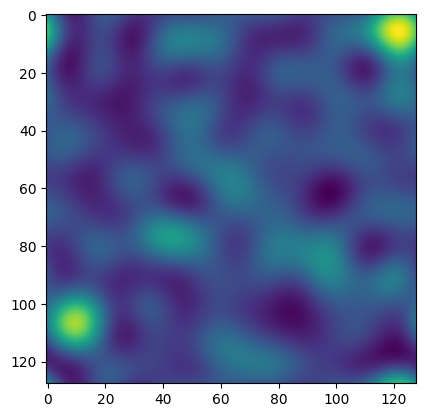

In [33]:
plt.imshow(low_batch[0,:,:,0])

In [28]:
for X_batch, y_batch in train_dataset.take(1):
    predictions = cnn_model.predict(X_batch)
    # Obtener el tamaño del batch
    batch_size = X_batch.shape[0]
    # Reconstruir imágenes de baja y alta frecuencia
    reconstructed_images = reconstruct_batch_images(*predictions, batch_size)




2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


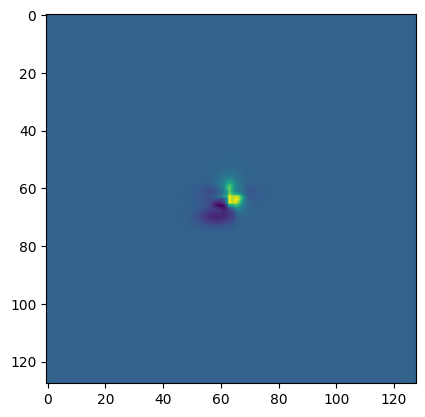

In [27]:
plt.imshow(reconstructed_images[1,:,:,0])

In [ ]:
for X_batch, y_batch in train_dataset.take(1):
    batch_size = X_batch.shape[0]

    reconstructed_images = reconstruct_batch_images(*predictions, batch_size)

    truth = preprocess_ybatch(y_batch)
    truth_reconstructed_images = reconstruct_batch_images(*truth, batch_size)

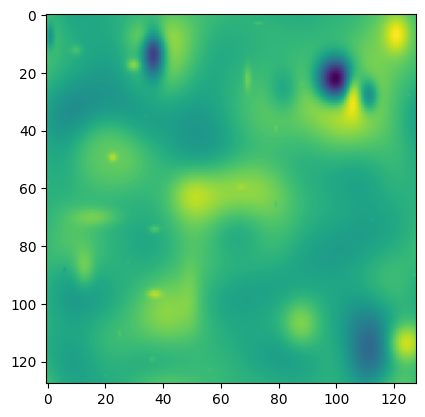

In [29]:
plt.imshow(truth_reconstructed_images[1,:,:,0])

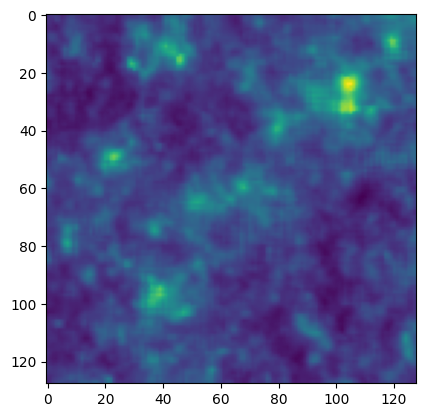

In [30]:
plt.imshow(y_batch[1,:,:,0])